이미지 분류기

일반 CPU 활용 시

In [2]:
# # 라이브러리 정의 
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np
# import pandas as pd

cuda nvidia gpu 활용 시

In [4]:
# How to check if the code is running on GPU or CPU?

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11887219552399883596
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1443813785
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16723502886646983198
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


intel gpu 활용 시

In [3]:
# import numpy as np
# import os

# # intel gpu 적용
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# import keras
# # mnist 데이터셋 
# from keras.datasets import mnist


### 라이브러리 불러오기

In [5]:
import warnings
warnings.filterwarnings(action="ignore")

In [12]:
import os, shutil

import cv2
from datetime import datetime
from tensorflow import keras
# One-Hot Encoding, Model Plot
from tensorflow.keras.utils import to_categorical, plot_model
# Add Model
from tensorflow.keras import Sequential
# Add Model Layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
# Model Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# Split Data to Train-Test
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


# 1. 데이터 불러오기 및 분리

#### 2-1. 테스트 데이터 분리

In [8]:
org_train_path='../images/cat_dog/input/train'
copy_train_path = '../images/cat_dog/datasets'

In [9]:
def copy_files(category_path, start_num, end_num, train_val_path):
    ## 이동 대상 이미지 파일경로 리스트에 담기
    image_paths = []
    for i in range(start_num, end_num):
        try:
            image_paths.append(os.path.join(org_train_path, category_path+"."+str(i)+".jpg"))
        except Exception as e:
            print(e)
            pass
    ## 이동할 폴더 경로 담기
    target_copy_paths = os.path.join(copy_train_path, train_val_path, category_path)

    # 신규 디렉토리가 존재하지 않으면 생성
    if not os.path.isdir(target_copy_paths):
        os.makedirs(target_copy_paths)

    for image_path in image_paths:
        ## shutil(원본경로, 이동할경로)
        shutil.copy(image_path, target_copy_paths)
    print("copy job complited")

In [10]:
copy_files("dog",0,10000,"train")
copy_files("cat",0,10000,"train")

copy job complited
copy job complited


In [11]:
copy_files("dog",10000,12500,"validation")
copy_files("cat",10000,12500,"validation")

copy job complited
copy job complited


#### 2-2. 데이터 호출

In [16]:
def read_img_files(basedir, imgSize):
    imageList = []
    labelList = []
    categories = os.listdir(basedir)
    # 분류 폴더 순환
    for i in range(len(categories)):
        labelPath = os.path.join(basedir, categories[i])
        labelPath

        imagePath = os.listdir(labelPath)
        # 폴더별 이미지 순환
        for j in range(len(imagePath)):
            imageFullPath = os.path.join(labelPath, imagePath[j])
            try:
                _img = cv2.imread(imageFullPath, cv2.IMREAD_GRAYSCALE)

                #### 2-1. 이미지 사이즈 변경
                resizedImg = cv2.resize(_img, (imgSize, imgSize))

                imageList.append(resizedImg)
                labelList.append(i)
            except Exception as e:
                print(e, imageFullPath)
                pass
    return np.array(imageList), np.array(labelList)

In [17]:
basedir='../images/cat_dog/datasets/train/'
IMG_SIZE = 48

imageArray, labelArray = read_img_files(basedir, IMG_SIZE)

In [18]:
categories = os.listdir(basedir)

print(categories)

['cat', 'dog']


In [19]:
# trainData와 testData로 분리
trainData_features,\
testData_features,\
trainData_labels,\
testData_labels = \
    train_test_split(imageArray, labelArray, test_size=0.2, random_state=2)

print(trainData_features.shape, testData_features.shape)
print(trainData_labels.shape, testData_labels.shape)

(16000, 48, 48) (4000, 48, 48)
(16000,) (4000,)


In [20]:
# CNN 사용을 위해 features 구조 변경
trainData_features = \
    trainData_features.reshape(len(trainData_features), IMG_SIZE, IMG_SIZE, 1)
testData_features = \
    testData_features.reshape(len(testData_features), IMG_SIZE, IMG_SIZE, 1)

print(trainData_features.shape, testData_features.shape)

(16000, 48, 48, 1) (4000, 48, 48, 1)


In [21]:
# feature 정규화
trainData_features_norm = trainData_features/255.0
testData_features_norm = testData_features/255.0

print(trainData_features_norm.shape, testData_features_norm.shape)

(16000, 48, 48, 1) (4000, 48, 48, 1)


In [22]:
# softmax와 결합을 위한 label one-hot encoding
trainData_labels_one = to_categorical(trainData_labels)
testData_labels_one = to_categorical(testData_labels)

print(trainData_labels_one.shape, testData_labels_one.shape)

(16000, 2) (4000, 2)


### 3. 모델 생성

데이터 입출력 구조 확인

In [23]:
inputShape = trainData_features[0].shape
inputShape

outputShape = len(categories)
outputShape

2

In [24]:
# 모델 초기화
model = Sequential()

In [25]:
# 모델 정의
model.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding="same",
                 activation="relu",
                 input_shape=inputShape)) # 초기 레이어 선언

model.add(MaxPool2D(pool_size=2))

model.add(Dropout(0.4)) # 사용할 비율 명시

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding="same",
                 activation="relu"))

model.add(MaxPool2D(pool_size=2))

model.add(Flatten())

model.add(Dense(units=outputShape,
                activation="softmax"))

In [26]:
# 모델 Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                

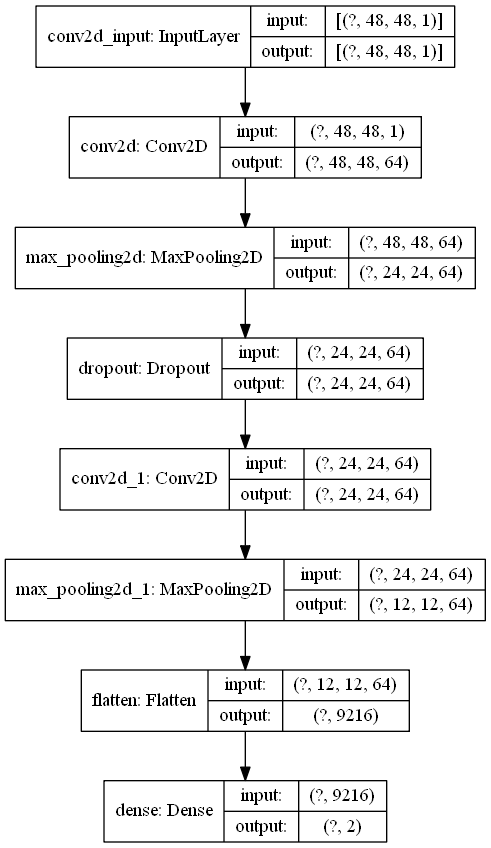

In [27]:
plot_model(model, show_shapes=True)

### 4. 모델 컴파일

In [28]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### 5. 모델 학습(훈련) 

In [29]:
epochNo = 5

now = datetime.now()
logdt = now.strftime("%Y%m%d_%H%M%S")
logdate = os.path.join("log_pets",logdt)

callback_list = [
    EarlyStopping(monitor="val_loss",patience=10),
    ModelCheckpoint(filepath="./mnist_pets.h5",monitor="val_loss",save_best_only=True, verbose=1),
    TensorBoard(log_dir=logdate, write_graph=True, write_images=True)
]

model.fit(x=trainData_features_norm,
          y=trainData_labels_one,
          epochs=epochNo,
          batch_size=32,
          validation_data=(testData_features_norm, testData_labels_one))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 13s 831us/sample - loss: 0.6493 - accuracy: 0.6144 - val_loss: 0.6028 - val_accuracy: 0.6740
Epoch 2/5
16000/16000 [==============================] - 10s 609us/sample - loss: 0.5807 - accuracy: 0.7021 - val_loss: 0.5379 - val_accuracy: 0.7372
Epoch 3/5
16000/16000 [==============================] - 10s 610us/sample - loss: 0.5208 - accuracy: 0.7494 - val_loss: 0.5202 - val_accuracy: 0.7558
Epoch 4/5
16000/16000 [==============================] - 10s 613us/sample - loss: 0.4907 - accuracy: 0.7666 - val_loss: 0.5106 - val_accuracy: 0.7527
Epoch 5/5
16000/16000 [==============================] - 10s 614us/sample - loss: 0.4672 - accuracy: 0.7798 - val_loss: 0.5009 - val_accuracy: 0.7595


### 6. 모델 추론

In [30]:
basedir2='../images/cat_dog/datasets/validation/'

imageArray2, labelArray2 = read_img_files(basedir2, IMG_SIZE)

print(categories)

['cat', 'dog']


In [31]:
validData_features = imageArray2.reshape(len(imageArray2), IMG_SIZE, IMG_SIZE, 1)

print(validData_features.shape)

(5000, 48, 48, 1)


In [32]:
validData_features_norm = validData_features/255.0

print(validData_features_norm.shape)

(5000, 48, 48, 1)


In [33]:
# softmax와 결합을 위한 label one-hot encoding
validData_label_one = to_categorical(labelArray2)

print(validData_label_one.shape)

(5000, 2)


In [34]:
model.evaluate(x=validData_features_norm,
               y=validData_label_one)

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.49792420768737794, 0.762]

### 7. 모델 예측 및 분류

In [35]:
def refineImage(testImg):
    # Color to Gray
    greyImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2GRAY)
    # greyImg.shape

    # Image Resize
    resizeImg = cv2.resize(greyImg, (IMG_SIZE, IMG_SIZE))
    # resizeImg.shape

    # Image Reshape
    predictImg = resizeImg.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    # predictImg.shape

    ## Image Normalization
    predictImg_norm = predictImg/255.0
    
    return predictImg_norm

In [36]:
testPath = "../images/cat_dog/input/test/"
predictCopyPath = "../images/cat_dog/output"

for i in range(len(categories)):
    _copyDir = os.path.join(predictCopyPath, categories[i])
    if not os.path.isdir(_copyDir):
            os.makedirs(_copyDir)

In [37]:
testImagePath = os.listdir(testPath)
len(testImagePath)

12500

In [38]:
for i in range(len(testImagePath)):
    imageFullPath = os.path.join(testPath, testImagePath[i])
    try:
        # 이미지 호출
        _img = cv2.imread(imageFullPath, cv2.IMREAD_COLOR)
        # 이미지 정형화
        testImg = refineImage(_img)
        # 예측
        _predict = categories[np.argmax(model.predict(testImg))]
        # 복사경로 설정
        _copyPath = os.path.join(predictCopyPath, _predict, testImagePath[i])
        # 복사
        shutil.copy(imageFullPath, _copyPath)
    except Exception as e:
            print(e, imageFullPath)
            pass

### 8. 모델 저장

In [35]:
# 모델의 구조 저장
model_json = model.to_json()
with open("D:/model_pets.json", "w") as json_file:
    json_file.write(model_json)

GPU 메모리 릴리즈

In [ ]:
from tensorflow.keras import backend as K

K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()